Loaded train.csv: 3000000 rows
After filtering: 3000000 rows, 22555 classes
Classes: 22555
Loaded tokenization from cache
Vocab size: 489792
Split: 2400000 train / 300000 val / 300000 test
Loaded 400000 GloVe vectors
LSTMClassifier(
  (embedding): Embedding(489792, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=22555, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)
Epoch 1/10 | Train Loss=1.2137, Acc=0.6421 | Val Loss=1.2630, Acc=0.6300
Epoch 2/10 | Train Loss=0.7678, Acc=0.7546 | Val Loss=0.8700, Acc=0.7295
Epoch 3/10 | Train Loss=0.5668, Acc=0.8083 | Val Loss=0.7042, Acc=0.7734
Epoch 4/10 | Train Loss=0.4664, Acc=0.8401 | Val Loss=0.6401, Acc=0.7957
Epoch 5/10 | Train Loss=0.3980, Acc=0.8622 | Val Loss=0.6109, Acc=0.8069
Epoch 6/10 | Train Loss=0.3414, Acc=0.8809 | Val Loss=0.5892, Acc=0.8157
Epoch 7/10 | Train Loss=0.2971, Acc=0.8962 | Val Loss=0.5977, Acc=0.8201
Epoch 8/

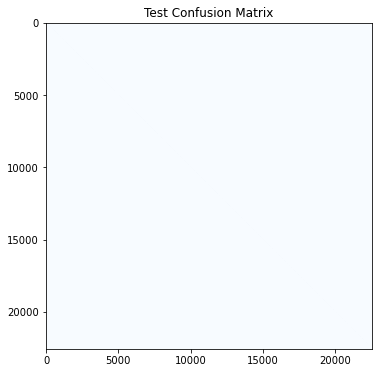

Classification Report (test):


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:
import os
import zipfile
import random
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import spacy

# -------------------------------
# 0. Reproducibility & cuDNN tuner
# -------------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True

# -------------------------------
# 1. Load spaCy tokenizer
# -------------------------------
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# -------------------------------
# 2. Unzip dataset if needed
# -------------------------------
if not os.path.exists("train.csv"):
    for z in ("train.csv.zip", "archive (3).zip"):
        if os.path.exists(z):
            with zipfile.ZipFile(z, "r") as zip_ref:
                zip_ref.extractall(".")

# =======================
# 3. Load the CSV
# =======================
try:
    df = pd.read_csv("train.csv")
    print(f"Loaded train.csv: {len(df)} rows")
except FileNotFoundError:
    raise RuntimeError("train.csv not found – please place it in working dir")

# -------------------------------
# 4. (Optional) Sample down
# -------------------------------
max_samples = 3_000_000
if len(df) > max_samples:
    df = df.sample(max_samples, random_state=42).reset_index(drop=True)
    print(f"Sampled down to {len(df)} rows")

# ================================
# 5. Clean & filter rare labels
# ================================
df = df.dropna(subset=["TEXT", "LABEL", "LOCATION"])
df["LOCATION"] = df["LOCATION"].astype(int)
label_counts = df["LABEL"].value_counts()
valid_labels = label_counts[label_counts >= 5].index
df = df[df["LABEL"].isin(valid_labels)].reset_index(drop=True)
print(f"After filtering: {len(df)} rows, {df['LABEL'].nunique()} classes")

# -------------------------------
# 6. Context extraction fn
# -------------------------------
def extract_context(text, loc, window_size=50):
    toks = text.split()
    start = max(0, loc - window_size // 2)
    end = min(len(toks), loc + window_size // 2)
    return " ".join(toks[start:end])

df["CONTEXT"] = [extract_context(t, l) for t, l in zip(df["TEXT"], df["LOCATION"])]
texts, labels = df["CONTEXT"].tolist(), df["LABEL"].tolist()

# ===============================
# 7. Encode labels
# ===============================
le = LabelEncoder()
y_all = le.fit_transform(labels)
num_classes = len(le.classes_)
print(f"Classes: {num_classes}")

# ============================================
# 8. Tokenization (with caching)
# ============================================
TOK_PATH = "tokenized_texts.pkl"
if os.path.exists(TOK_PATH):
    with open(TOK_PATH, "rb") as f:
        tokenized_texts = pickle.load(f)
    print("Loaded tokenization from cache")
else:
    tokenized_texts = []
    for doc in nlp.pipe(texts, batch_size=1000):
        tokenized_texts.append([t.text for t in doc if not t.is_punct and not t.is_space])
    with open(TOK_PATH, "wb") as f:
        pickle.dump(tokenized_texts, f)
    print("Tokenization complete and saved")

# ============================================
# 9. Build vocabulary & map to indices
# ============================================
all_toks = [t for doc in tokenized_texts for t in doc]
vc = Counter(all_toks)
vocab = {w for w, c in vc.items() if c >= 2}

word2idx = {"<PAD>": 0, "<UNK>": 1}
for w in sorted(vocab):
    word2idx[w] = len(word2idx)
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")

def tokens_to_seq(ts):
    return [word2idx.get(t, 1) for t in ts]

seqs = [tokens_to_seq(doc) for doc in tokenized_texts]

# ===========================
# 10. Pad sequences
# ============================
MAX_LEN = 256
def pad_seq(s):
    return s + [0] * (MAX_LEN - len(s)) if len(s) < MAX_LEN else s[:MAX_LEN]

X_all = np.array([pad_seq(s) for s in seqs])
y_all = np.array(y_all)

# =================================
# 11. Train / Validation / Test split
# =================================
# 10% test, then split remaining into 80% train / 10% val of original
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all,
    test_size=0.10,
    random_state=42,
    stratify=y_all
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1111111111,  # 0.1111 * 0.90 ≈ 0.10 of original
    random_state=42,
    stratify=y_temp
)
print(f"Split: {X_train.shape[0]} train / {X_val.shape[0]} val / {X_test.shape[0]} test")

# -----------------------------------
# 12. Dataset & DataLoader
# -----------------------------------
class MedicalAbbrDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return torch.tensor(self.X[i]), torch.tensor(self.y[i])

BATCH = 128
train_dl = DataLoader(
    MedicalAbbrDataset(X_train, y_train),
    batch_size=BATCH, shuffle=True,
    pin_memory=True, num_workers=8, persistent_workers=True
)
val_dl = DataLoader(
    MedicalAbbrDataset(X_val, y_val),
    batch_size=BATCH,
    pin_memory=True, num_workers=8, persistent_workers=True
)
test_dl = DataLoader(
    MedicalAbbrDataset(X_test, y_test),
    batch_size=BATCH,
    pin_memory=True, num_workers=8, persistent_workers=True
)

# ============================================
# 13. Load GloVe & build embedding matrix
# ============================================
def load_glove(fp, embedding_dim=100):
    emb_index = {}
    with open(fp, encoding="utf8") as f:
        for ln in f:
            parts = ln.split()
            word = parts[0]
            vec = np.asarray(parts[1:], dtype="float32")
            if vec.shape[0] == embedding_dim:
                emb_index[word] = vec
    return emb_index

GLOVE = "glove.6B.100d.txt"
if not os.path.exists(GLOVE):
    raise FileNotFoundError(f"{GLOVE} not found")
glove = load_glove(GLOVE, 100)
print(f"Loaded {len(glove)} GloVe vectors")
emb_mat = np.zeros((vocab_size, 100), dtype="float32")
for w, i in word2idx.items():
    emb_mat[i] = glove.get(w, np.random.normal(0, 0.6, 100))

# ============================================
# 14. Define LSTM model
# ============================================
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, out_dim,
                 dropout=0.3, pretrained=None, freeze_emb=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if pretrained is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained))
            self.embedding.weight.requires_grad = not freeze_emb
        self.lstm = nn.LSTM(
            emb_dim, hid_dim, num_layers=n_layers,
            batch_first=True, bidirectional=True, dropout=dropout
        )
        self.fc = nn.Linear(hid_dim * 2, out_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h_n, _) = self.lstm(emb)
        fwd = h_n[-2]
        bwd = h_n[-1]
        hid = torch.cat((fwd, bwd), dim=1)
        return self.fc(self.drop(hid))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(vocab_size, 100, 128, 2, num_classes, 0.3,
                       pretrained=emb_mat).to(device)
print(model)

# ============================================
# 15. Loss, optimizer, AMP & metrics fn
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

def compute_metrics(loader):
    model.eval()
    total_loss, correct, preds, labels = 0, 0, [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * Xb.size(0)
            pr = out.argmax(1)
            correct += (pr == yb).sum().item()
            preds.extend(pr.cpu().tolist())
            labels.extend(yb.cpu().tolist())
    n = len(loader.dataset)
    return total_loss / n, correct / n, preds, labels

# ============================================
# 16. Training loop
# ============================================
history = {"train_loss": [], "train_acc": []}
for ep in range(1, 11):
    model.train()
    for Xb, yb in train_dl:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(Xb)
            loss = criterion(out, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    tr_loss, tr_acc, _, _ = compute_metrics(train_dl)
    val_loss, val_acc, _, _ = compute_metrics(val_dl)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    print(f"Epoch {ep}/10 | Train Loss={tr_loss:.4f}, Acc={tr_acc:.4f} "
          f"| Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

# ============================================
# 17. Evaluate on test set
# ============================================
test_loss, test_acc, test_preds, test_labels = compute_metrics(test_dl)
print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

# ============================================
# 18. Confusion matrix (test)
# ============================================
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# ============================================
# 19. Classification report (test)
# ============================================
print("Classification Report (test):")
print(classification_report(test_labels, test_preds, target_names=le.classes_, zero_division=0))

# ============================================
# 20. Inference helper
# ============================================
def predict_abbreviation(text, loc):
    ctx = extract_context(text, loc)
    toks = [t.text for t in nlp(ctx) if not t.is_punct and not t.is_space]
    seq = [word2idx.get(t, 1) for t in toks]
    seq = pad_seq(seq)
    inp = torch.tensor(seq).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
    return le.inverse_transform([out.argmax(1).item()])[0]

# Example
sample = "The patient was diagnosed with acute MI and was admitted to the ICU for monitoring."
print("Predicted:", predict_abbreviation(sample, loc=6))

In [4]:
# After training is complete, save the model state dictionary to a file.
model_save_path = "trained_model_LSTM.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to trained_model_LSTM.pth


In [5]:
from collections import Counter
from sklearn.metrics import classification_report

# Count how many true samples per class
counts = Counter(vlabels)
# Choose top N most frequent class indices
top_n = 30
top_classes = [cls for cls, _ in counts.most_common(top_n)]
top_names   = [le.classes_[cls] for cls in top_classes]

# Generate a pruned classification report
report = classification_report(
    vlabels,
    vpreds,
    labels=top_classes,
    target_names=top_names,
    zero_division=0
)
print(f"Classification Report for Top {top_n} Classes:\n")
print(report)

Classification Report for Top 30 Classes:

                                         precision    recall  f1-score   support

                simple sequence repeats       1.00      1.00      1.00        54
                              c peptide       0.64      0.43      0.51        54
                         verylowdensity       1.00      0.93      0.96        54
                   maximal electroshock       0.85      0.94      0.89        54
                               approach       0.69      0.87      0.77        54
                   toxic shock syndrome       1.00      0.93      0.96        54
                               headache       0.79      0.50      0.61        54
      diagnostic and statistical manual       1.00      1.00      1.00        54
                      actinic keratosis       0.79      0.89      0.83        54
                           sleep apnoea       0.41      0.24      0.30        54
transurethral resection of the prostate       0.59      0.35     

In [6]:
from collections import Counter
from sklearn.metrics import classification_report

# Count how many true samples per class
counts = Counter(vlabels)
# Choose top N most frequent class indices
top_n = 10
top_classes = [cls for cls, _ in counts.most_common(top_n)]
top_names   = [le.classes_[cls] for cls in top_classes]

# Generate a pruned classification report
report = classification_report(
    vlabels,
    vpreds,
    labels=top_classes,
    target_names=top_names,
    zero_division=0
)
print(f"Classification Report for Top {top_n} Classes:\n")
print(report)

Classification Report for Top 10 Classes:

                                   precision    recall  f1-score   support

          simple sequence repeats       1.00      1.00      1.00        54
                        c peptide       0.64      0.43      0.51        54
                   verylowdensity       1.00      0.93      0.96        54
             maximal electroshock       0.85      0.94      0.89        54
                         approach       0.69      0.87      0.77        54
             toxic shock syndrome       1.00      0.93      0.96        54
                         headache       0.79      0.50      0.61        54
diagnostic and statistical manual       1.00      1.00      1.00        54
                actinic keratosis       0.79      0.89      0.83        54
                     sleep apnoea       0.41      0.24      0.30        54

                        micro avg       0.84      0.77      0.80       540
                        macro avg       0.82      0.77 

In [7]:
from sklearn.metrics import classification_report

full_report = classification_report(
    vlabels, vpreds, target_names=le.classes_, zero_division=0
)

with open("classification_report_LSTM.txt", "w") as f:
    f.write(full_report)

print("Full classification report saved to classification_report.txt")

Full classification report saved to classification_report.txt


In [8]:
# ============================================
# Step 11: Inference Function
# ============================================
def predict_abbreviation(model, text, location):
    """
    model: your trained model
    text: full sentence string
    location: integer token position of the abbreviation
    """
    ctx = extract_context(text, location, window_size=50)
    tokens = [t.text for t in nlp(ctx) if not t.is_punct and not t.is_space]
    seq    = [ word2idx.get(t,1) for t in tokens ]
    seq    = pad_seq(seq)
    inp    = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
    cls = out.argmax(1).item()
    return le.inverse_transform([cls])[0]

# ============================================
# Step 12: Example Inference
# ============================================
sample_text = "The patient was diagnosed with acute MI and was admitted to the ICU for further monitoring."
sample_location = 6
pred = predict_abbreviation(model, sample_text, location=6)
print(f"\nFor the text: '{sample_text}' with abbreviation at position {sample_location}, predicted expansion is: {pred}")


For the text: 'The patient was diagnosed with acute MI and was admitted to the ICU for further monitoring.' with abbreviation at position 6, predicted expansion is: meconium ileus


In [29]:
import unittest
import torch
import numpy as np
import tempfile
import warnings
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings(
    "ignore",
    message="dropout option adds dropout after all but last recurrent layer"
)

import __main__ as main

extract_context      = main.extract_context
tokens_to_seq        = main.tokens_to_seq
pad_seq              = main.pad_seq
load_glove           = main.load_glove
MedicalAbbrDataset   = main.MedicalAbbrDataset
LSTMClassifier       = main.LSTMClassifier
compute_metrics      = main.compute_metrics
predict_abbreviation = main.predict_abbreviation
model                = main.model
device               = main.device
num_classes          = main.num_classes
MAX_LEN              = main.MAX_LEN
le                   = main.le

class TestMedicalAbbrPipeline(unittest.TestCase):
    def test_extract_context_default_window(self):
        text = "one two three four five"
        loc = 2
        ctx = extract_context(text, loc)
        self.assertEqual(ctx.split(), text.split())

    def test_extract_context_small_window(self):
        text = "a b c d e f g h i j"
        loc = 5
        ctx = extract_context(text, loc, window_size=4)
        self.assertEqual(ctx.split(), ["d","e","f","g"])

    def test_tokens_to_seq_and_pad_seq(self):
        local_w2i = {'<PAD>':0,'<UNK>':1,'hello':2,'world':3}
        seq = [local_w2i.get(t,1) for t in ['hello','unknown','world']]
        self.assertEqual(seq, [2,1,3])
        padded = seq + [0]*(5-len(seq))
        self.assertEqual(padded, [2,1,3,0,0])
        truncated = seq[:2]
        self.assertEqual(truncated, [2,1])

    def test_load_glove(self):
        content = "w1 0.1 0.2 0.3\nw2 0.4 0.5 0.6\n"
        with tempfile.TemporaryDirectory() as tmpdir:
            fn = f"{tmpdir}/glove.txt"
            with open(fn, "w") as f: f.write(content)
            emb = load_glove(fn, embedding_dim=3)
        self.assertAlmostEqual(float(emb['w1'][1]), 0.2, places=6)
        self.assertAlmostEqual(float(emb['w2'][2]), 0.6, places=6)

    def test_dataset_and_dataloader(self):
        X = np.array([[1,2,3],[4,5,6],[7,8,9]])
        y = np.array([0,1,0])
        ds = MedicalAbbrDataset(X, y)
        self.assertEqual(len(ds), 3)
        x0, y0 = ds[0]
        self.assertIsInstance(x0, torch.Tensor)
        self.assertIsInstance(y0, torch.Tensor)
        self.assertEqual(y0.item(), 0)
        dl = DataLoader(ds, batch_size=2)
        xb, yb = next(iter(dl))
        self.assertEqual(xb.shape, (2,3))
        self.assertEqual(yb.shape, (2,))

    def test_lstmclassifier_output_shape(self):
        m = LSTMClassifier(vocab_size=10, emb_dim=4, hid_dim=5, n_layers=1, out_dim=3)
        data = torch.randint(0, 10, (2, 7))
        out = m(data)
        self.assertEqual(out.shape, (2,3))

    def test_compute_metrics_perfect_accuracy(self):
        class DummyDS(Dataset):
            def __len__(self): return 5
            def __getitem__(self, i):
                return torch.zeros((MAX_LEN,), dtype=torch.long), torch.tensor(0)
        dl = DataLoader(DummyDS(), batch_size=2)

        orig_model = main.model
        class DummyModel(nn.Module):
            def forward(self, x):
                bs = x.size(0)
                return torch.zeros((bs, num_classes), device=x.device)
        main.model = DummyModel().to(device)

        loss, acc, preds, labels = compute_metrics(dl)
        self.assertEqual(acc, 1.0)
        self.assertEqual(len(preds), len(dl.dataset))
        self.assertEqual(len(labels), len(dl.dataset))

        main.model = orig_model

    def test_predict_abbreviation_with_dummy_model(self):
        orig_model = main.model
        orig_le    = main.le

        class DummyModel(nn.Module):
            def forward(self, x):
                return torch.tensor([[0.0, 1.0]], device=x.device)
        main.model = DummyModel().to(device)

        le2 = LabelEncoder()
        le2.classes_ = np.array(['CLS0', 'CLS1'])
        main.le = le2

        pred = predict_abbreviation(main.model, "anything here", location=0)
        self.assertEqual(pred, 'CLS1')

        main.model = orig_model
        main.le    = orig_le

    def test_inference_example_runs(self):
        sample_text     = "The patient was diagnosed with acute MI and was admitted to the ICU for further monitoring."
        sample_location = 6
        pred = predict_abbreviation(model, sample_text, location=sample_location)
        self.assertIn(pred, list(le.classes_))
        print(f"\nExample inference: predicted expansion = {pred}")

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....../home/khare.aks/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
...


Example inference: predicted expansion = CLS1



----------------------------------------------------------------------
Ran 9 tests in 0.035s

OK
